In [48]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [49]:
## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 200,  # to adjust notebook inline plot size
    'savefig.dpi': 200,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.5, 2.625], # 4 x 3
#     'figure.figsize': [4*1.125, 3*1.125], # 4x3, full slide in keynote
    'font.family': 'serif',
    'figure.max_open_warning':100,
    'axes.formatter.limits' : [-3, 3]
}
mpl.rcParams.update(params)

## Get physical constants from Scipy
import scipy.constants as con
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
# k = con.physical_constants['Boltzmann constant in eV/K'][0]

import scipy.integrate as int

import scipy.io as sio

import scipy.optimize as opt

import scipy.special as spl

In [50]:
" Testing %re+9 " %float(10**-9)

' Testing 1e-09e+9 '

In [51]:
2e-4/((375E-9)**2 * np.pi)

452707393.68361336

In [52]:
misloc_pack_path = os.path.join(
    os.path.sep,
    'Users',
    'chair',
    'Documents',
    'Academia',
    'SuperRes',
    'Biteen_colab',
    'Mispolarization',
    'python',
#     'gitted',
    )

sys.path.append(misloc_pack_path)

import misloc_mispol_package as mmp
import misloc_mispol_package.calc.coupled_dipoles as cp
import misloc_mispol_package.optics.anal_foc_diff_fields as aff

In [53]:
import twosphere_temperature as tst
import pti_model as pti

#### System parameters

In [54]:
1.473**2

2.1697290000000002

In [55]:
# a1 = 75
# a2 = 125
a1 = 10
a2 = 15
eps_back = 1.473**2
# eps_back = 1.8
# eps_back = 1.33**2

## Seperation in nm
d = 50

plot_hws = np.linspace(2.1, 2.6, 300)

sensorsize_nm = 1000
## pump power 600 micro watts = 600*1e-6 * 1e7 erg/s
# pump_power_watts = 600*1e-6 
ergpers_per_watt = 1e7
cm_per_nm = 1e-7

# pump_intensity = pump_power_watts*ergpers_per_watt/(300*cm_per_nm)**2.
## Define field magnitude from intensity in ergs/(cm^2*s)
# E_pump_mag = ((8*np.pi/c)*pump_intensity)**0.5 
# E_pump_mag = (pump_power_watts*ergpers_per_watt)**0.5
## Try Baffou intensity from APL 2009, DOI: 10.1063/1.3116645
pump_intensity_watts_per_cm2 = 1e5/2
pump_power_watts = (
    pump_intensity_watts_per_cm2 * np.pi*(150*cm_per_nm)**2
    )
E_pump_mag = (pump_power_watts*ergpers_per_watt)**0.5

## DEfine probe intensity
probe_power_watts = 1.1*1e-3 
probe_intensity = (
    probe_power_watts*ergpers_per_watt
    /(300*cm_per_nm)**2.
    )
E_probe_mag = ((8*np.pi/c)*probe_intensity)**0.5


## Fixed relationships
d_col_cm = np.array([[d, 0, 0]])*1e-7

## Assign material porperties of gold
# au_eps_inf=9.82335326  # eps_inf
# au_w_p=9.06705560/hbar  # w_p
# au_gamma=0.0334860149/hbar  # gamma
## BEM Drude parameters
au_eps_inf=10  # eps_inf
au_w_p=9.0705/hbar  # w_p
au_gamma=0.0660/hbar  # gamma

In [56]:
m_per_cm = 1e-2
pump_intensity_watts_per_cm2/(m_per_cm)**2

500000000.0

In [57]:
def alpha_1_of_hw(hw):
    return cp.sparse_Mie_sphere_polarizability_Drude(
        w=hw/hbar, 
#         eps_inf=14.2, 
#         w_p=10.0/hbar, 
#         gamma=0.20/hbar,
#         eps_b=1.33**2., 
        a=a1*1e-7, 
        eps_inf=au_eps_inf,  # eps_inf
        w_p=au_w_p,  # w_p
        gamma=au_gamma,  # gamma
        eps_b=eps_back,  # eps_b
#         a=41*1e-7
        )

def alpha_2_of_hw(hw):
    return cp.sparse_Mie_sphere_polarizability_Drude(
        w=hw/hbar, 
        eps_inf=au_eps_inf,  # eps_inf
        w_p=au_w_p,  # w_p
        gamma=au_gamma,  # gamma
        eps_b=eps_back,  # eps_b
        a=a2*1e-7, 
        )

sphere_1_scattering = (
    cp.sigma_prefactor(w=plot_hws/hbar, eps_b=eps_back)
    *
    np.abs(alpha_1_of_hw(plot_hws)[:, 0, 0])**2.
    )
sphere_2_scattering = (
    cp.sigma_prefactor(w=plot_hws/hbar, eps_b=eps_back)
    *
    np.abs(alpha_2_of_hw(plot_hws)[:, 0, 0])**2.
    )

# plt.plot(plot_hws, sphere_1_scattering)
# plt.plot(plot_hws, sphere_2_scattering)
# plt.title("Heterodimer Scattering")
# plt.xlabel('Photon Energy [eV]')
# plt.ylabel(r'$\sigma$ [$\mathrm{cm}^2$]')

def coupled_dips_of_w(w):
    return  cp.coupled_dip_mags_both_driven(
        mol_angle=0,
        plas_angle=0,
        d_col = d_col_cm,
        E_d_angle=None,
        drive_hbar_w=w*hbar,
        alpha0_diag=alpha_1_of_hw(w*hbar),
        alpha1_diag=alpha_2_of_hw(w*hbar),
        n_b=eps_back**0.5,
        drive_amp=E_pump_mag,)

# coupled_scattering = cp.sigma_scat_coupled(
#     dipoles_moments_per_omega=coupled_dips_of_w,
#     d_col=d_col_cm,
#     drive_hbar_w=plot_hws,
#     n_b=eps_back**0.5,
#     E_0=E_pump_mag,)

coupled_absorption = cp.sigma_abs_coupled(
    mol_angle=0,
    plas_angle=0,
    d_col = d_col_cm,
    E_d_angle=None,
    drive_hbar_w=plot_hws,
    alpha0_diag=alpha_1_of_hw(plot_hws),
    alpha1_diag=alpha_2_of_hw(plot_hws),
    n_b=eps_back**0.5,
    drive_amp=E_pump_mag,)

sphere_1_absorption = cp.single_dip_absorption(
    mol_angle=0,
    E_d_angle=0,
    alpha_0_p0=alpha_1_of_hw(plot_hws),
    drive_hbar_w=plot_hws,
    drive_amp=E_pump_mag,
    n_b=eps_back**0.5,)

sphere_2_absorption = cp.single_dip_absorption(
    mol_angle=0,
    E_d_angle=0,
    alpha_0_p0=alpha_2_of_hw(plot_hws),
    drive_hbar_w=plot_hws,
    drive_amp=E_pump_mag,
    n_b=eps_back**0.5,)

## Find mode energies
bond_enei = plot_hws[np.argmax(coupled_absorption[0])]
anti_enei = plot_hws[np.argmax(
    coupled_absorption[1][0]-coupled_absorption[1][1]
    -
    (coupled_absorption[1][2]-coupled_absorption[1][3])
#     coupled_scattering[1][1]*(plot_hws>2.4)
    )]

print(f'bond_enei = {bond_enei:.2f}')
print(f'anti_enei = {anti_enei:.2f}')

bond_enei = 2.35
anti_enei = 2.10


Plot dipole components of power absorbed

Text(0, 0.5, '$\\sigma$ [$\\mathrm{cm}^2$]')

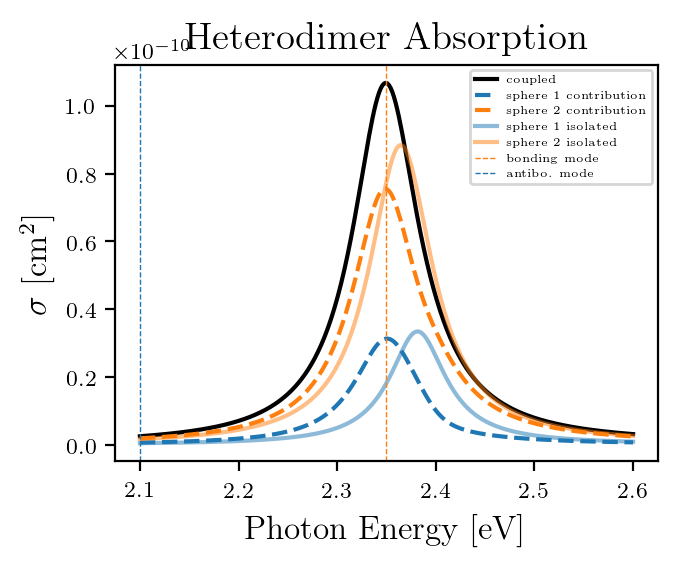

In [58]:
plt.plot(
    plot_hws, 
    coupled_absorption[1][0]-coupled_absorption[1][1]+coupled_absorption[1][2]-coupled_absorption[1][3], 
    c='k',
#     ls='',
#     marker='.',
#     markersize=.1,
    label='coupled')

plt.plot(
    plot_hws, 
    coupled_absorption[1][0]-coupled_absorption[1][1], 
    ls='--', 
    c='C0',
    label='sphere 1 contribution')
plt.plot(
    plot_hws, 
    coupled_absorption[1][2]-coupled_absorption[1][3], 
    ls='--', 
    c='C1',
    label='sphere 2 contribution')


plt.plot(
    plot_hws, 
    sphere_1_absorption, 
    alpha=.5, 
    c='C0',
    label='sphere 1 isolated')
plt.plot(
    plot_hws, 
    sphere_2_absorption, 
    alpha=.5, 
    c='C1',
    label='sphere 2 isolated')

## Mark mode energies
ylims=plt.gca().get_ylim()
plt.plot(
    [bond_enei, bond_enei], 
    [*ylims], 
    lw=0.5, 
    ls='--', 
    c='C1', 
    label='bonding mode'
    )
plt.plot(
    [anti_enei,anti_enei], 
    [*ylims], 
    lw=0.5, 
    ls='--', 
    c='C0', 
    label='antibo. mode'
    )
plt.ylim(*ylims)

plt.legend(fontsize=4)
plt.title("Heterodimer Absorption")
plt.xlabel('Photon Energy [eV]')
plt.ylabel(r'$\sigma$ [$\mathrm{cm}^2$]')

#### Load matlab spectra for comparison

In [59]:
import scipy.io as sio

a10_bem_spec_fig_file = sio.loadmat('matlab_abs_spectra/a10_abs.fig', squeeze_me=True, struct_as_record=False)
a10_bem_spec_hw = a10_bem_spec_fig_file['hgS_070000'].children[0].children[0].properties.XData
a10_bem_spec = a10_bem_spec_fig_file['hgS_070000'].children[0].children[0].properties.YData

a15_bem_spec_fig_file = sio.loadmat('matlab_abs_spectra/a15_abs.fig', squeeze_me=True, struct_as_record=False)
a15_bem_spec_hw = a15_bem_spec_fig_file['hgS_070000'].children[0].children[0].properties.XData
a15_bem_spec = a15_bem_spec_fig_file['hgS_070000'].children[0].children[0].properties.YData


coupled_spec_fig_file = sio.loadmat('matlab_abs_spectra/a1_10_a2_15_d3a1_abs.fig', squeeze_me=True, struct_as_record=False)
coupled_spec_hw = coupled_spec_fig_file['hgS_070000'].children[0].children[0].properties.XData
coupled_spec = coupled_spec_fig_file['hgS_070000'].children[0].children[0].properties.YData

Text(0, 0.5, '$\\sigma$ [$\\mathrm{cm}^2$]')

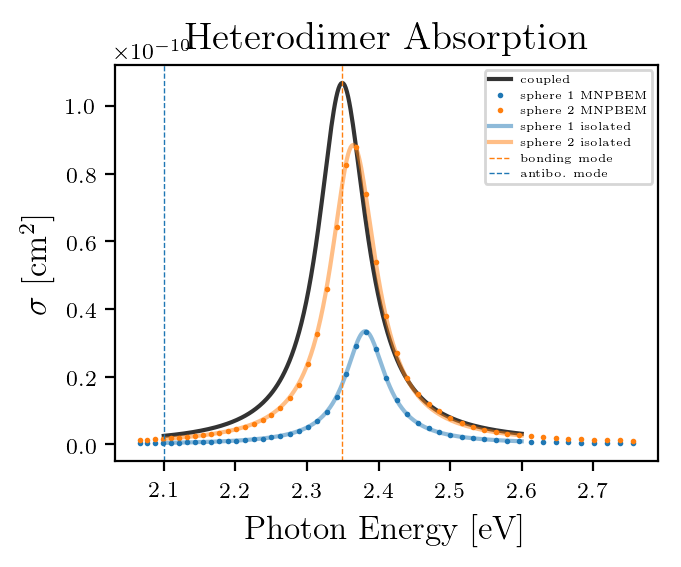

In [60]:
plt.plot(
    plot_hws, 
    coupled_absorption[1][0]-coupled_absorption[1][1]+coupled_absorption[1][2]-coupled_absorption[1][3], 
    c='k',
    alpha=.8,
    label='coupled')

plt.plot(
    a10_bem_spec_hw, 
    a10_bem_spec*1e-14, 
    C='C0',
    ls='', 
    marker='o', 
    markersize=1,
    label='sphere 1 MNPBEM')

plt.plot(
    a15_bem_spec_hw, 
    a15_bem_spec*1e-14, 
    C='C1',
    ls='', 
    marker='o', 
    markersize=1,
    label='sphere 2 MNPBEM')

# plt.plot(
#     coupled_spec_hw,
#     coupled_spec*1e-14, 
#     C='k',
#     ls='', 
#     marker='o', 
#     markersize=1,
#     label='coupled MNPBEM')

plt.plot(
    plot_hws, 
    sphere_1_absorption, 
    alpha=.5, 
    c='C0',
    label='sphere 1 isolated')
plt.plot(
    plot_hws, 
    sphere_2_absorption, 
    alpha=.5, 
    c='C1',
    label='sphere 2 isolated')

## Mark mode energies
ylims=plt.gca().get_ylim()
plt.plot(
    [bond_enei, bond_enei], 
    [*ylims], 
    lw=0.5, 
    ls='--', 
    c='C1', 
    label='bonding mode'
    )
plt.plot(
    [anti_enei,anti_enei], 
    [*ylims], 
    lw=0.5, 
    ls='--', 
    c='C0', 
    label='antibo. mode'
    )
plt.ylim(*ylims)

plt.legend(fontsize=4)
plt.title("Heterodimer Absorption")
plt.xlabel('Photon Energy [eV]')
plt.ylabel(r'$\sigma$ [$\mathrm{cm}^2$]')

which supports what I would have expected, that the larger sphere is dominating absorption at the low energy mode

# CAlculate coupled abs for pump excitation

In [61]:
eps_at_bond = cp.drude_model(
    w=bond_enei/hbar, 
    eps_inf=au_eps_inf,  # eps_inf
    w_p=au_w_p,  # w_p
    gamma=au_gamma,)
eps_at_anti = cp.drude_model(
    w=anti_enei/hbar, 
    eps_inf=au_eps_inf,  # eps_inf
    w_p=au_w_p,  # w_p
    gamma=au_gamma,)

## Back to calcs

In [62]:
bond_alpha_1 = alpha_1_of_hw(bond_enei)
bond_alpha_2 = alpha_2_of_hw(bond_enei)

np.sum(intensity_ofx) = 3.496708258343281e+44
(2*spot_size)**2. = 5.135237550894e-09
beam_power = 7.18257102110623e+30
np.sum(intensity_ofx) = 1.7844125958684416e+44
(2*spot_size)**2. = 6.426116254761331e-09
beam_power = 4.5867371150044213e+30


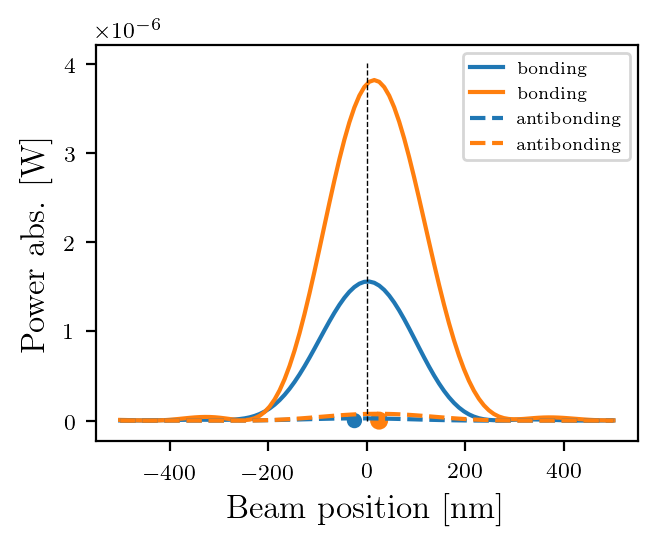

In [63]:
obs_points = np.linspace(-sensorsize_nm/2, sensorsize_nm/2, 100)*1e-7

bond_p1_pumped, bond_p2_pumped = cp.coupled_dip_mags_focused_beam(
    mol_angle=0,
    plas_angle=0,
    d_col = -d_col_cm,
    p0_position=-d_col_cm/2,
    beam_x_positions=obs_points,
    E_d_angle=0,
    drive_hbar_w=bond_enei,
    alpha0_diag=alpha_1_of_hw(bond_enei),
    alpha1_diag=alpha_2_of_hw(bond_enei),
    n_b=eps_back**0.5,
    drive_amp=E_pump_mag,
    return_polarizabilities=False,
    )

bond_p1_pumped_pow_cgs = cp.power_absorped(
    bond_p1_pumped, 
    alpha_1_of_hw(bond_enei),
    bond_enei,
    n_b=eps_back**0.5)

bond_p2_pumped_pow_cgs = cp.power_absorped(
    bond_p2_pumped, 
    alpha_2_of_hw(bond_enei),
    bond_enei,
    n_b=eps_back**0.5)

## Antibonding mode
# obs_points = np.linspace(-sensorsize_nm/2, sensorsize_nm/2, 100)*1e-7

anti_p1_pumped, anti_p2_pumped = cp.coupled_dip_mags_focused_beam(
    mol_angle=0,
    plas_angle=0,
    d_col=-d_col_cm,
    p0_position=-d_col_cm/2,
    beam_x_positions=obs_points,
    E_d_angle=0,
    drive_hbar_w=anti_enei,
    alpha0_diag=alpha_1_of_hw(anti_enei),
    alpha1_diag=alpha_2_of_hw(anti_enei),
    n_b=eps_back**0.5,
    drive_amp=E_pump_mag,
    return_polarizabilities=False,
    )

anti_p1_pumped_pow_cgs = cp.power_absorped(
    anti_p1_pumped, 
    alpha_1_of_hw(anti_enei),
    anti_enei,
    n_b=eps_back**0.5)

anti_p2_pumped_pow_cgs = cp.power_absorped(
    anti_p2_pumped, 
    alpha_2_of_hw(anti_enei),
    anti_enei,
    n_b=eps_back**0.5)

## Convert powers to SI
bond_p1_pumped_pow_si = bond_p1_pumped_pow_cgs/ergpers_per_watt
bond_p2_pumped_pow_si = bond_p2_pumped_pow_cgs/ergpers_per_watt
anti_p1_pumped_pow_si = anti_p1_pumped_pow_cgs/ergpers_per_watt
anti_p2_pumped_pow_si = anti_p2_pumped_pow_cgs/ergpers_per_watt

## Make plots
plt.plot(obs_points*1e7, bond_p1_pumped_pow_si, label='bonding')
plt.plot(obs_points*1e7, bond_p2_pumped_pow_si, label='bonding')

plt.plot(obs_points*1e7, anti_p1_pumped_pow_si, ls='--', label='antibonding', c='C0')
plt.plot(obs_points*1e7, anti_p2_pumped_pow_si, ls='--', label='antibonding', c='C1')

plt.xlabel('Beam position [nm]')
plt.ylabel('Power abs. [W]')
## plot positions
plt.scatter(
    np.asarray([-1, 1])*d/2,
    [0,0],
    c=['C0','C1'],
    s=[a1*2,a2*2])
plt.plot([0,0], [0,plt.gca().get_ylim()[1]], lw=0.5, ls='--', c='black')

plt.legend(fontsize=6)

## Calculate temperatures
but first we need flux from power absorbed

In [64]:
sph_1_area_si = 4*np.pi*(a1*1e-9)**2.
sph_2_area_si = 4*np.pi*(a2*1e-9)**2.

bond_flux_1 = bond_p1_pumped_pow_si / sph_1_area_si
bond_flux_2 = bond_p2_pumped_pow_si / sph_2_area_si

anti_flux_1 = anti_p1_pumped_pow_si / sph_1_area_si
anti_flux_2 = anti_p2_pumped_pow_si / sph_2_area_si

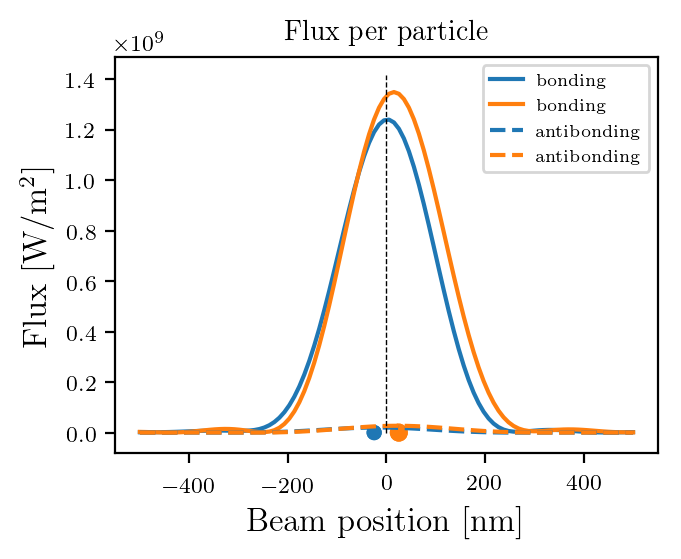

In [65]:
plt.plot(obs_points*1e7, bond_flux_1, label='bonding')
plt.plot(obs_points*1e7, bond_flux_2, label='bonding')
plt.ylabel(r'Flux [W/$\mathrm{m}^2$]')
## plot positions
plt.scatter(
    np.asarray([-1, 1])*d/2,
    [0,0],
    c=['C0','C1'],
    s=[a1*2,a2*2])
plt.title('Bonding mode', fontsize=10)
plt.xlabel('Beam position [nm]')

plt.plot(obs_points*1e7, anti_flux_1, ls='--', label='antibonding', c='C0')
plt.plot(obs_points*1e7, anti_flux_2, ls='--', label='antibonding', c='C1')
plt.ylabel(r'Flux [W/$\mathrm{m}^2$]')
## plot positions
plt.scatter(
    np.asarray([-1, 1])*d/2,
    [0,0],
    c=['C0','C1'],
    s=[a1*2,a2*2])
plt.plot([0,0], [0,plt.gca().get_ylim()[1]], lw=0.5, ls='--', c='black')

plt.title('Flux per particle', fontsize=10)
plt.xlabel('Beam position [nm]')
plt.legend(fontsize=6)

In [66]:
epsilon = 2*a1/d
l2_on_l1 = a2/a1

epsilon

0.4

In [67]:
 ## Try this again 
bond_flux_ratios = bond_flux_2 / bond_flux_1

bond_temps = np.zeros_like(bond_flux_ratios)
bond_temps = bond_temps[None, :]*np.ones((2,1))

for i, q_ratio in enumerate(bond_flux_ratios):
    bond_temps[0, i] = tst.hetero_sph_unitless_temp(
        which_sphere=1,
        epsilon=epsilon, 
        max_m=4, 
        B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
        l2_on_l1=l2_on_l1, 
        q2_on_q1=q_ratio)
    bond_temps[1, i] = tst.hetero_sph_unitless_temp(
        which_sphere=2,
        epsilon=epsilon, 
        max_m=4, 
        B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
        l2_on_l1=l2_on_l1, 
        q2_on_q1=q_ratio)
    

## Antibonding Mode calculation

anti_temps = np.zeros_like(bond_flux_ratios)
anti_temps = anti_temps[None, :]*np.ones((2,1))

for i, q_ratio in enumerate(anti_flux_2/anti_flux_1):
    anti_temps[0, i] = tst.hetero_sph_unitless_temp(
        which_sphere=1,
        epsilon=epsilon, 
        max_m=4, 
        B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
        l2_on_l1=l2_on_l1, 
        q2_on_q1=q_ratio)
    anti_temps[1, i] = tst.hetero_sph_unitless_temp(
        which_sphere=2,
        epsilon=epsilon, 
        max_m=4, 
        B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
        l2_on_l1=l2_on_l1, 
        q2_on_q1=q_ratio)




Text(0, 0.5, '$\\theta$')

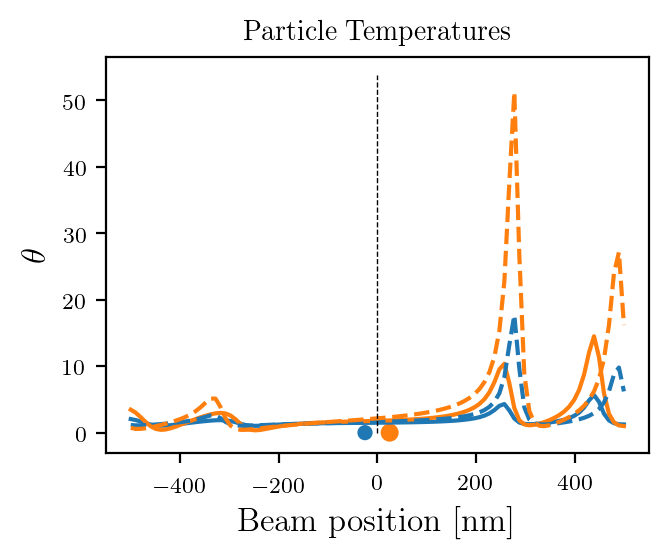

In [68]:
## Make Plots
plt.plot(
    obs_points*1e7, 
    (bond_temps[0, :]), 
    label='bonding')
plt.plot(
    obs_points*1e7, 
    (bond_temps[1, :]), 
    label='bonding')

plt.plot(
    obs_points*1e7, 
    (anti_temps[0, :]), 
    ls='--', label='antibonding', c='C0')
plt.plot(
    obs_points*1e7, 
    (anti_temps[1, :]), 
    ls='--', label='antibonding', c='C1')

plt.scatter(
    np.asarray([-1, 1])*d/2,
    [0,0],
    c=['C0','C1'],
    s=[a1*2,a2*2])
plt.plot([0,0], [0,plt.gca().get_ylim()[1]], lw=0.5, ls='--', c='black')
plt.title('Particle Temperatures', fontsize=10)
plt.xlabel('Beam position [nm]')
plt.ylabel(r'$\theta$')

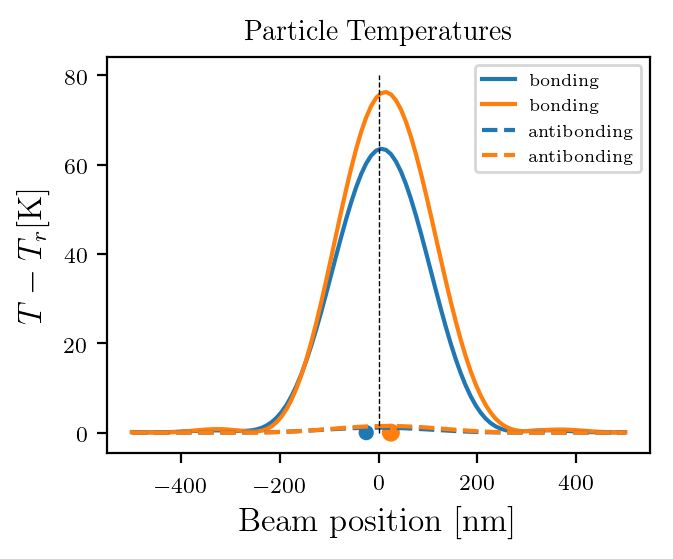

In [69]:
## Convert Temperature to Kelvin
kappa_glycerol = 0.292 
def bond_temp_to_kelvin(theta):
    return theta*(bond_flux_1*a1*1e-9/kappa_glycerol)
def anti_temp_to_kelvin(theta):
    return theta*(anti_flux_1*a1*1e-9/kappa_glycerol)

## Make Plots
plt.plot(
    obs_points*1e7, 
    bond_temp_to_kelvin(bond_temps[0, :]), 
    label='bonding')
plt.plot(
    obs_points*1e7, 
    bond_temp_to_kelvin(bond_temps[1, :]), 
    label='bonding')

plt.plot(
    obs_points*1e7, 
    anti_temp_to_kelvin(anti_temps[0, :]), 
    ls='--', label='antibonding', c='C0')
plt.plot(
    obs_points*1e7, 
    anti_temp_to_kelvin(anti_temps[1, :]), 
    ls='--', label='antibonding', c='C1')

plt.scatter(
    np.asarray([-1, 1])*d/2,
    [0,0],
    c=['C0','C1'],
    s=[a1*2,a2*2])
plt.plot([0,0], [0,plt.gca().get_ylim()[1]], lw=0.5, ls='--', c='black')
plt.title('Particle Temperatures', fontsize=10)
plt.xlabel('Beam position [nm]')
plt.ylabel(r'$T-T_r [\mathrm{K}]$')
plt.legend(fontsize=6)

# Build PTImages

In [70]:
probe_enei = 2.5
b1 = 1
b2 = 1

bond_heated_particles = pti.temperature_dependent_particle(
    probe_enei, 
    eps_inf=au_eps_inf, 
    w_p=au_w_p,
    gamma=au_gamma,
    E_probe=E_probe_mag)

bond_conf_image = bond_heated_particles.conf_PTI(
    obs_points*1e7, 
    probe_enei, 
    T1=bond_temp_to_kelvin(bond_temps[0, :]), 
    b1=a1+b1, 
    T2=bond_temp_to_kelvin(bond_temps[1, :]), 
    b2=a2+b2, 
    d=d, 
    a1=a1, 
    a2=a2,)


bond_conf_image_components = bond_heated_particles.conf_PTI(
    obs_points*1e7, 
    probe_enei, 
    T1=bond_temp_to_kelvin(bond_temps[0, :]), 
    b1=a1+b1, 
    T2=bond_temp_to_kelvin(bond_temps[1, :]), 
    b2=a2+b2, 
    d=d, 
    a1=a1, 
    a2=a2,
    return_components=True)


### Calculate widefield image 

bond_p1_wf_pumped_cgs, bond_p2_wf_pumped_cgs = cp.coupled_dip_mags_both_driven(
    mol_angle=0,
    plas_angle=0,
    d_col=-d_col_cm,
    E_d_angle=0,
    drive_hbar_w=bond_enei,
    alpha0_diag=alpha_1_of_hw(bond_enei),
    alpha1_diag=alpha_2_of_hw(bond_enei),
    n_b=eps_back**0.5,
    drive_amp=E_pump_mag,
    return_polarizabilities=False,
    )

bond_p1_wf_pumped_pow_cgs = cp.power_absorped(
    bond_p1_wf_pumped_cgs, 
    alpha_1_of_hw(bond_enei),
    bond_enei,
    n_b=eps_back**0.5)

bond_p2_wf_pumped_pow_cgs = cp.power_absorped(
    bond_p2_wf_pumped_cgs, 
    alpha_2_of_hw(bond_enei),
    bond_enei,
    n_b=eps_back**0.5)


bond_flux_wf_1 = (
    bond_p1_wf_pumped_pow_cgs/ergpers_per_watt / sph_1_area_si
    )
bond_flux_wf_2 = (
    bond_p2_wf_pumped_pow_cgs/ergpers_per_watt / sph_2_area_si
    )
q_ratio = (bond_flux_wf_2/bond_flux_wf_1)[0]
## Calculate sphere temperatures
bond_temps_wf = [0, 0]
bond_temps_wf[0] = tst.hetero_sph_unitless_temp(
    which_sphere=1,
    epsilon=epsilon, 
    max_m=4, 
    B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
    l2_on_l1=l2_on_l1, 
    q2_on_q1=q_ratio)
bond_temps_wf[1] = tst.hetero_sph_unitless_temp(
    which_sphere=2,
    epsilon=epsilon, 
    max_m=4, 
    B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
    l2_on_l1=l2_on_l1, 
    q2_on_q1=q_ratio)

def bond_temp_to_kelvin_wf(theta):
    return theta*(bond_flux_wf_1*a1*1e-9/kappa_glycerol)

bond_wifi_image = bond_heated_particles.wfi_pti(
    l=obs_points*1e7, 
    w=probe_enei/hbar, 
    T1=bond_temp_to_kelvin_wf(bond_temps_wf[0]), 
    b1=a1+b1, 
    T2=bond_temp_to_kelvin_wf(bond_temps_wf[1]), 
    b2=a2+b2, 
    d=d, 
    a1=a1, 
    a2=a2,)


# plt.plot(
#     obs_points*1e7,
#     np.abs(bond_conf_image)/np.abs(bond_conf_image).max(),
#     label='confocal',
#     c='C3')

# plt.plot(
#     obs_points*1e7,
#     np.abs(bond_wifi_image)/np.abs(bond_wifi_image).max(),
#     label='widefield',
#     c='C4')

# plt.scatter(
#     np.asarray([-1, 1])*d/2,
#     [0,0],
#     c=['C0','C1'],
#     s=[a1*2,a2*2])
# plt.plot([0,0], [0,plt.gca().get_ylim()[1]], lw=0.5, ls='--', c='black')

# plt.legend()
# plt.title("Bonding mode PTImages")
# plt.xlabel('[nm]')
# plt.ylabel('PT signal')


np.sum(intensity_ofx) = 5.079483615834672e+44
(2*spot_size)**2. = 4.534267629359594e-09
beam_power = 9.21269525325663e+30
np.sum(intensity_ofx) = 5.079483615834672e+44
(2*spot_size)**2. = 4.534267629359594e-09
beam_power = 9.21269525325663e+30
np.sum(intensity_ofx) = 5.079483615834672e+44
(2*spot_size)**2. = 4.534267629359594e-09
beam_power = 9.21269525325663e+30
np.sum(intensity_ofx) = 5.079483615834672e+44
(2*spot_size)**2. = 4.534267629359594e-09
beam_power = 9.21269525325663e+30


In [71]:
bond_temp_to_kelvin_wf(bond_temps_wf[1])

array([43.29988673])

In [72]:
probe_enei = 2.5

anti_heated_particles = pti.temperature_dependent_particle(
    probe_enei, 
    eps_inf=au_eps_inf, 
    w_p=au_w_p,
    gamma=au_gamma,
    E_probe=E_probe_mag)

anti_conf_image = anti_heated_particles.conf_PTI(
    obs_points*1e7, 
    probe_enei, 
    T1=anti_temp_to_kelvin(anti_temps[0, :]), 
    b1=a1+5, 
    T2=anti_temp_to_kelvin(anti_temps[1, :]), 
    b2=a2+5, 
    d=d, 
    a1=a1, 
    a2=a2,)


anti_conf_image_components = anti_heated_particles.conf_PTI(
    obs_points*1e7, 
    probe_enei, 
    T1=anti_temp_to_kelvin(anti_temps[0, :]), 
    b1=a1+5, 
    T2=anti_temp_to_kelvin(anti_temps[1, :]), 
    b2=a2+5, 
    d=d, 
    a1=a1, 
    a2=a2,
    return_components=True)


### Calculate widefield image 
anti_p1_wf_pumped_cgs, anti_p2_wf_pumped_cgs = cp.coupled_dip_mags_both_driven(
    mol_angle=0,
    plas_angle=0,
    d_col=-d_col_cm,
    E_d_angle=0,
    drive_hbar_w=anti_enei,
    alpha0_diag=alpha_1_of_hw(anti_enei),
    alpha1_diag=alpha_2_of_hw(anti_enei),
    n_b=eps_back**0.5,
    drive_amp=E_pump_mag,
    return_polarizabilities=False,
    )

anti_p1_wf_pumped_pow_cgs = cp.power_absorped(
    anti_p1_wf_pumped_cgs, 
    alpha_1_of_hw(anti_enei),
    anti_enei,
    n_b=eps_back**0.5)

anti_p2_wf_pumped_pow_cgs = cp.power_absorped(
    anti_p2_wf_pumped_cgs, 
    alpha_2_of_hw(anti_enei),
    anti_enei,
    n_b=eps_back**0.5)


anti_flux_wf_1 = (
    (anti_p1_wf_pumped_pow_cgs/ergpers_per_watt) / sph_1_area_si
    )
anti_flux_wf_2 = (
    (anti_p2_wf_pumped_pow_cgs/ergpers_per_watt) / sph_2_area_si
    )
q_ratio = (anti_flux_wf_2/anti_flux_wf_1)[0]
## Calculate sphere temperatures
anti_temps_wf = [0, 0]

anti_temps_wf[0] = tst.hetero_sph_unitless_temp(
    which_sphere=1,
    epsilon=epsilon, 
    max_m=4, 
    B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
    l2_on_l1=l2_on_l1, 
    q2_on_q1=q_ratio)
anti_temps_wf[1] = tst.hetero_sph_unitless_temp(
    which_sphere=2,
    epsilon=epsilon, 
    max_m=4, 
    B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
    l2_on_l1=l2_on_l1, 
    q2_on_q1=q_ratio)

def anti_temp_to_kelvin_wf(theta):
    return theta*(anti_flux_wf_1*a1*1e-9/kappa_glycerol)

anti_wifi_image = anti_heated_particles.wfi_pti(
    l=obs_points*1e7, 
    w=probe_enei/hbar, 
    T1=anti_temp_to_kelvin_wf(anti_temps_wf[0]), 
    b1=a1+5, 
    T2=anti_temp_to_kelvin_wf(anti_temps_wf[1]), 
    b2=a2+5, 
    d=d, 
    a1=a1, 
    a2=a2,)


# plt.plot(
#     obs_points*1e7,
#     np.abs(anti_conf_image)/np.abs(anti_conf_image).max(),
#     label='confocal',
#     c='C3')

# plt.plot(
#     obs_points*1e7,
#     np.abs(anti_wifi_image)/np.abs(anti_wifi_image).max(),
#     label='widefield',
#     c='C4')

# plt.scatter(
#     np.asarray([-1, 1])*d/2,
#     [0,0],
#     c=['C0','C1'],
#     s=[a1*2,a2*2])
# plt.plot([0,0], [0,plt.gca().get_ylim()[1]], lw=0.5, ls='--', c='black')

# plt.legend()
# plt.title("Antibonding mode PTImages")
# plt.xlabel('[nm]')
# plt.ylabel('PT signal')

np.sum(intensity_ofx) = 5.079483615834672e+44
(2*spot_size)**2. = 4.534267629359594e-09
beam_power = 9.21269525325663e+30
np.sum(intensity_ofx) = 5.079483615834672e+44
(2*spot_size)**2. = 4.534267629359594e-09
beam_power = 9.21269525325663e+30
np.sum(intensity_ofx) = 5.079483615834672e+44
(2*spot_size)**2. = 4.534267629359594e-09
beam_power = 9.21269525325663e+30
np.sum(intensity_ofx) = 5.079483615834672e+44
(2*spot_size)**2. = 4.534267629359594e-09
beam_power = 9.21269525325663e+30


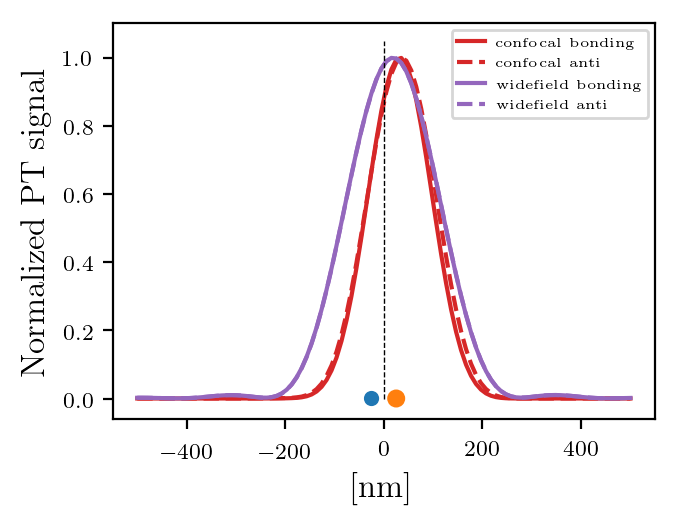

In [73]:
plt.plot(
    obs_points*1e7,
    (bond_conf_image)/np.abs(bond_conf_image).max(),
    label='confocal bonding',
    c='C3')
plt.plot(
    obs_points*1e7,
    (anti_conf_image)/np.abs(anti_conf_image).max(),
    label='confocal anti',
    ls = '--',
    c='C3'
    )


plt.plot(
    obs_points*1e7,
    (bond_wifi_image)/np.abs(bond_wifi_image).max(),
    label='widefield bonding',
    c='C4')


plt.plot(
    obs_points*1e7,
    (anti_wifi_image)/np.abs(anti_wifi_image).max(),
    label='widefield anti',
    ls = '--',
    c='C4'
    )


plt.plot([0,0], [0,plt.gca().get_ylim()[1]], lw=0.5, ls='--', c='black')
# plt.xlim(-200, 200)
plt.legend(fontsize=5)
plt.xlabel('[nm]')
plt.ylabel('Normalized PT signal')
plt.scatter(
    np.asarray([-1, 1])*d/2,
    [0,0],
    c=['C0','C1'],
    s=[a1*2,a2*2])

Check temperature of sphere from Baffou paper

In [74]:
T = 1/(4*np.pi)*(20*1e-6/(kappa_glycerol*25*1e-9))
T

218.02046998889773

In [75]:
kappa_glycerol


0.292

In [76]:
T = (1/(4*np.pi))*(8*1e-6/(.6*25*1e-9))
T

42.44131815783875

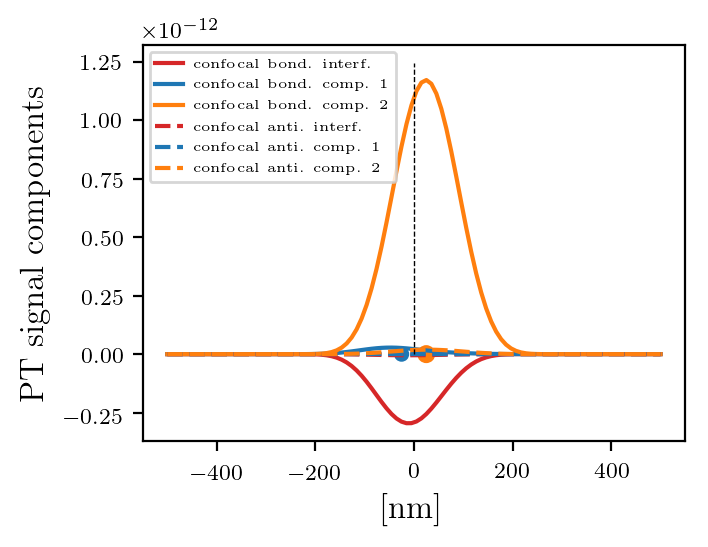

In [77]:
plt.plot(
    obs_points*1e7,
    (bond_conf_image_components[0][0] - bond_conf_image_components[1][0]),
    label='confocal bond. interf.',
    c='C3')
plt.plot(
    obs_points*1e7,
    (bond_conf_image_components[0][1] - bond_conf_image_components[1][1]),
    label='confocal bond. comp. 1',
    c='C0')
plt.plot(
    obs_points*1e7,
    (bond_conf_image_components[0][2] - bond_conf_image_components[1][2]),
    label='confocal bond. comp. 2',
    c='C1')

plt.plot(
    obs_points*1e7,
    (anti_conf_image_components[0][0] - anti_conf_image_components[1][0]),
    label='confocal anti. interf.',
    c='C3',
    ls='--')
plt.plot(
    obs_points*1e7,
    (anti_conf_image_components[0][1] - anti_conf_image_components[1][1]),
    label='confocal anti. comp. 1',
    c='C0',
    ls='--')
plt.plot(
    obs_points*1e7,
    (anti_conf_image_components[0][2] - anti_conf_image_components[1][2]),
    label='confocal anti. comp. 2',
    c='C1',
    ls='--')
# plt.plot(
#     obs_points*1e7,
#     (bond_conf_image_components[0]),
#     label='confocal bonding 2',
#     c='k')

# plt.plot(
#     obs_points*1e7,
#     (anti_conf_image_components),
#     label='confocal anti',
#     ls = '--',
#     c='C3'
#     )


# plt.plot(
#     obs_points*1e7,
#     (bond_wifi_image)/np.abs(bond_wifi_image).max(),
#     label='widefield bonding',
#     c='C4')


# plt.plot(
#     obs_points*1e7,
#     (anti_wifi_image)/np.abs(anti_wifi_image).max(),
#     label='widefield anti',
#     ls = '--',
#     c='C4'
#     )


plt.plot([0,0], [0,plt.gca().get_ylim()[1]], lw=0.5, ls='--', c='black')
# plt.xlim(-200, 200)
plt.legend(fontsize=5)
plt.xlabel('[nm]')
plt.ylabel('PT signal components')
plt.scatter(
    np.asarray([-1, 1])*d/2,
    [0,0],
    c=['C0','C1'],
    s=[a1*2,a2*2])

Text(0, 0.5, '$\\sigma$ [$\\mathrm{cm}^2$]')

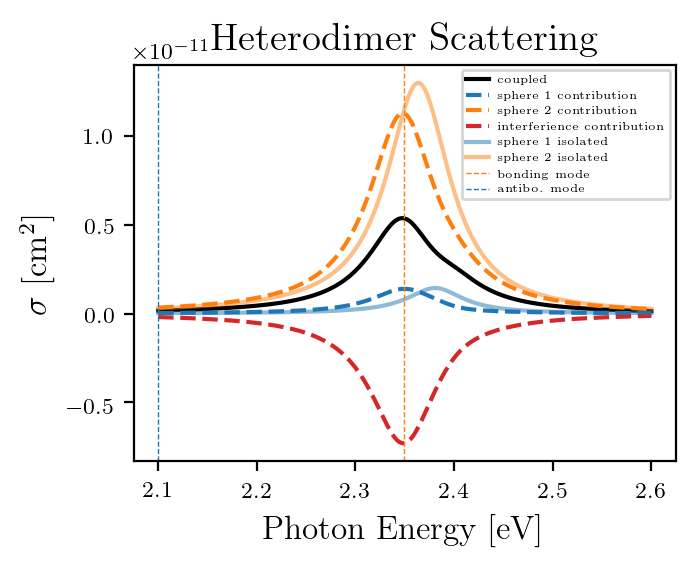

In [78]:
# plot_hws = np.linspace(2, 2.6, 100)
sphere_1_scattering = (
    cp.sigma_prefactor(w=plot_hws/hbar, eps_b=eps_back)
    *
    np.abs(alpha_1_of_hw(plot_hws)[:, 0, 0])**2.
    )
sphere_2_scattering = (
    cp.sigma_prefactor(w=plot_hws/hbar, eps_b=eps_back)
    *
    np.abs(alpha_2_of_hw(plot_hws)[:, 0, 0])**2.
    )
coupled_scattering = cp.sigma_scat_coupled(
    dipoles_moments_per_omega=coupled_dips_of_w,
    d_col=d_col_cm,
    drive_hbar_w=plot_hws,
    n_b=eps_back**0.5,
    E_0=E_pump_mag,)

plt.plot(
    plot_hws, 
    coupled_scattering[1][0]+coupled_scattering[1][1]+coupled_scattering[1][2], 
    c='k',
#     ls='',
#     marker='.',
#     markersize=.1,
    label='coupled')
# plt.plot(plot_hws, coupled_scattering[1][2], label='sphere 1 component')
# plt.plot(plot_hws, coupled_scattering[1][2], label='sphere 1 component')

plt.plot(
    plot_hws, 
    coupled_scattering[1][1], 
    ls='--', 
    c='C0',
    label='sphere 1 contribution')
plt.plot(
    plot_hws, 
    coupled_scattering[1][2], 
    ls='--', 
    c='C1',
    label='sphere 2 contribution')
plt.plot(
    plot_hws, 
    coupled_scattering[1][0], 
    ls='--', 
    c='C3',
    label='interferience contribution')


plt.plot(
    plot_hws, 
    sphere_1_scattering, 
    alpha=.5, 
    c='C0',
    label='sphere 1 isolated')
plt.plot(
    plot_hws, 
    sphere_2_scattering, 
    alpha=.5, 
    c='C1',
    label='sphere 2 isolated')

## Mark mode energies
ylims=plt.gca().get_ylim()
plt.plot(
    [bond_enei, bond_enei], 
    [*ylims], 
    lw=0.5, 
    ls='--', 
    c='C1', 
    label='bonding mode'
    )
plt.plot(
    [anti_enei,anti_enei], 
    [*ylims], 
    lw=0.5, 
    ls='--', 
    c='C0', 
    label='antibo. mode'
    )
plt.ylim(*ylims)

plt.legend(fontsize=4)
plt.title("Heterodimer Scattering")
plt.xlabel('Photon Energy [eV]')
plt.ylabel(r'$\sigma$ [$\mathrm{cm}^2$]')